In [90]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import joblib


In [91]:
data=pd.read_parquet(r'C:\Users\alqay\OneDrive\Desktop\store-sales-time-series-forecasting-normalized-final')

In [92]:
nulls=data.isnull().sum()
nulls[nulls>0].index

Index([], dtype='object')

In [93]:
data.head()

,date,store_nbr,family,unit_sales,onpromotion,city,state,store_type,perishable,transactions,...,sales_roll_mean_14,sales_roll_mean_28,trans_lag_1,trans_lag_7,trans_lag_14,trans_roll_mean_7,trans_roll_mean_14,mean_transactions_family,mean_transactions_store,mean_transactions_store_family
1716381,2013-02-06,1,0,1.0,0,18,12,3,0,1853,...,3.142857,2.714286,6856.0,3885.0,1786.0,4270.571429,3828.500000,8357.451252,47138.102711,4386.810663
1458126,2013-02-07,1,0,1.0,0,18,12,3,0,1727,...,3.142857,2.678571,1853.0,1084.0,4167.0,3980.285714,3833.285714,8357.451252,47138.102711,4386.810663
425588,2013-02-08,1,0,2.0,0,18,12,3,0,3756,...,2.857143,2.607143,1727.0,3476.0,1521.0,4072.142857,3659.000000,8357.451252,47138.102711,4386.810663
1070834,2013-02-09,1,0,4.0,0,18,12,3,0,4416,...,2.785714,2.571429,3756.0,3544.0,1770.0,4112.142857,3818.642857,8357.451252,47138.102711,4386.810663
1716600,2013-02-10,1,0,1.0,0,18,12,3,0,374,...,3.000000,2.535714,4416.0,5631.0,1762.0,4236.714286,4007.642857,8357.451252,47138.102711,4386.810663


In [94]:
data.columns

Index(['date', 'store_nbr', 'family', 'unit_sales', 'onpromotion', 'city',
       'state', 'store_type', 'perishable', 'transactions', 'oil_price',
       'day_type', 'Event Scale', 'locale_name', 'temperature',
       'precipitation', 'year', 'month', 'day', 'day_of_week', 'quarter',
       'is_weekend', 'is_month_start', 'is_month_end', 'weekofyear',
       'dayofweek', 'sales_lag_1', 'sales_lag_7', 'sales_lag_14',
       'sales_lag_28', 'sales_roll_mean_7', 'sales_roll_mean_14',
       'sales_roll_mean_28', 'trans_lag_1', 'trans_lag_7', 'trans_lag_14',
       'trans_roll_mean_7', 'trans_roll_mean_14', 'mean_transactions_family',
       'mean_transactions_store', 'mean_transactions_store_family'],
      dtype='object')

In [95]:
data=data[data['unit_sales']>0]
data=data[data['transactions']>0]

In [96]:
# Updated Features (excluding transactions-related features)
features = [
    'store_nbr', 'family', 'onpromotion', 'perishable',
    'oil_price', 'temperature', 'precipitation',
    'day_of_week', 'is_month_start', 'is_month_end',
    'month', 'year', 'store_type', 'city', 'state',
    'day_type', 'Event Scale', 'locale_name','transactions',
    'sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_28',
    'sales_roll_mean_7', 'sales_roll_mean_14', 'sales_roll_mean_28',
    
]



data.fillna(-1, inplace=True)

# Handle inf/-inf
for col in data.select_dtypes(include=[np.number]):
    data[col].replace([np.inf, -np.inf], -1, inplace=True)
    data[col].fillna(-1, inplace=True)


# === Split Train/Validation ===
train = data[data['date'] < '2017-07-01']
valid = data[data['date'] >= '2017-07-01']

# === Prepare Features & Targets ===
X_train = train[features]
X_valid = valid[features]

y_train_sales_log = np.log1p(train['unit_sales'])
y_valid_sales_log = np.log1p(valid['unit_sales'])

# === LightGBM Parameters ===
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.02,
    'num_leaves': 70,
    'max_depth': 8,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 1,
    'lambda_l2': 1,
    'seed': 42,
    'verbosity': -1
}



# === Train Sales Model ===
train_data_sales = lgb.Dataset(X_train, label=y_train_sales_log)
valid_data_sales = lgb.Dataset(X_valid, label=y_valid_sales_log)

model_sales = lgb.train(
    params,
    train_data_sales,
    valid_sets=[train_data_sales, valid_data_sales],
    num_boost_round=20000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=300),
        lgb.log_evaluation(period=500)
    ]
)

# === Predict and Evaluate Sales ===
y_pred_sales_log = model_sales.predict(X_valid, num_iteration=model_sales.best_iteration)
y_pred_sales = np.expm1(y_pred_sales_log)

rmsle_sales = np.sqrt(mean_squared_log_error(valid['unit_sales'], np.maximum(0, y_pred_sales)))
print(f"Validation RMSLE (unit_sales): {rmsle_sales:.5f}")


Training until validation scores don't improve for 300 rounds
[500]	training's rmse: 0.313728	valid_1's rmse: 0.300151
[1000]	training's rmse: 0.301047	valid_1's rmse: 0.289223
[1500]	training's rmse: 0.295063	valid_1's rmse: 0.285047
[2000]	training's rmse: 0.291232	valid_1's rmse: 0.282733
[2500]	training's rmse: 0.288302	valid_1's rmse: 0.281238
[3000]	training's rmse: 0.285999	valid_1's rmse: 0.280383
[3500]	training's rmse: 0.283923	valid_1's rmse: 0.279676
[4000]	training's rmse: 0.282099	valid_1's rmse: 0.279135
[4500]	training's rmse: 0.280438	valid_1's rmse: 0.278619
[5000]	training's rmse: 0.278895	valid_1's rmse: 0.278191
[5500]	training's rmse: 0.277404	valid_1's rmse: 0.277919
[6000]	training's rmse: 0.276021	valid_1's rmse: 0.277626
[6500]	training's rmse: 0.274685	valid_1's rmse: 0.277359
[7000]	training's rmse: 0.273444	valid_1's rmse: 0.277171
[7500]	training's rmse: 0.272229	valid_1's rmse: 0.276969
[8000]	training's rmse: 0.271094	valid_1's rmse: 0.276789
[8500]	trai

In [97]:
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error

# Ensure non-negative predictions for RMSLE
y_pred_sales_final = np.maximum(0, final_preds)

# === Final Model Evaluation ===
rmsle_sales = np.sqrt(mean_squared_log_error(valid['unit_sales'], y_pred_sales_final))
rmse_sales = np.sqrt(mean_squared_error(valid['unit_sales'], y_pred_sales_final))
mean_sales = valid['unit_sales'].mean()
r2_sales = r2_score(valid['unit_sales'], y_pred_sales_final)

print("=== Final LightGBM Unit Sales Evaluation ===")
print(f"RMSLE: {rmsle_sales:.5f}")
print(f"RMSE: {rmse_sales:.2f}")
print(f"Mean unit_sales: {mean_sales:.2f}")
print(f"Relative RMSE: {(rmse_sales / mean_sales):.2%}")
print(f"R² Score: {r2_sales:.4f}")


=== Final LightGBM Unit Sales Evaluation ===
RMSLE: 0.27590
RMSE: 38.40
Mean unit_sales: 140.67
Relative RMSE: 27.29%
R² Score: 0.9661


In [98]:
data.head()

,date,store_nbr,family,unit_sales,onpromotion,city,state,store_type,perishable,transactions,...,sales_roll_mean_14,sales_roll_mean_28,trans_lag_1,trans_lag_7,trans_lag_14,trans_roll_mean_7,trans_roll_mean_14,mean_transactions_family,mean_transactions_store,mean_transactions_store_family
1716381,2013-02-06,1,0,1.0,0,18,12,3,0,1853,...,3.142857,2.714286,6856.0,3885.0,1786.0,4270.571429,3828.500000,8357.451252,47138.102711,4386.810663
1458126,2013-02-07,1,0,1.0,0,18,12,3,0,1727,...,3.142857,2.678571,1853.0,1084.0,4167.0,3980.285714,3833.285714,8357.451252,47138.102711,4386.810663
425588,2013-02-08,1,0,2.0,0,18,12,3,0,3756,...,2.857143,2.607143,1727.0,3476.0,1521.0,4072.142857,3659.000000,8357.451252,47138.102711,4386.810663
1070834,2013-02-09,1,0,4.0,0,18,12,3,0,4416,...,2.785714,2.571429,3756.0,3544.0,1770.0,4112.142857,3818.642857,8357.451252,47138.102711,4386.810663
1716600,2013-02-10,1,0,1.0,0,18,12,3,0,374,...,3.000000,2.535714,4416.0,5631.0,1762.0,4236.714286,4007.642857,8357.451252,47138.102711,4386.810663


In [99]:
# Updated Features (excluding transactions-related features)
features = [
'store_nbr', 'family', 'onpromotion', 'perishable',
'oil_price', 'temperature', 'precipitation',
'day_of_week', 'is_month_start', 'is_month_end',
'month', 'year', 'store_type', 'city', 'state',
'day_type', 'Event Scale', 'locale_name',
'trans_lag_1', 'trans_lag_7', 'trans_lag_14', 'trans_roll_mean_7',
'trans_roll_mean_14'
]



# Handle inf/-inf
for col in data.select_dtypes(include=[np.number]):
    data[col].replace([np.inf, -np.inf], -1, inplace=True)
    data[col].fillna(-1, inplace=True)


#=== Clip Outliers in Targets ===
transactions_upper = data['transactions'].quantile(0.995)
data['transactions'] = data['transactions'].clip(upper=transactions_upper).apply(lambda x: max(x, 0))

#=== Split Train/Validation ===
train = data[data['date'] < '2017-07-01']
valid = data[data['date'] >= '2017-07-01']

##=== Prepare Features & Targets ===
X_train = train[features]
X_valid = valid[features]

y_train_transactions_log = np.log1p(train['transactions'])
y_valid_transactions_log = np.log1p(valid['transactions'])

#=== LightGBM Parameters ===
params = {
'objective': 'regression',
'metric': 'rmse',
'boosting_type': 'gbdt',
'learning_rate': 0.02,
'num_leaves': 256,
'max_depth': 8,
'feature_fraction': 0.8,
'bagging_fraction': 0.8,
'bagging_freq': 5,
'lambda_l1': 1,
'lambda_l2': 1,
'seed': 42,
'verbosity': -1
}

#=== Train Sales Model ===
train_data_transactions = lgb.Dataset(X_train, label=y_train_transactions_log)
valid_data_transactions = lgb.Dataset(X_valid, label=y_valid_transactions_log)

model_transactions = lgb.train(
params,
train_data_transactions,
valid_sets=[train_data_transactions, valid_data_transactions],
num_boost_round=20000,
callbacks=[
lgb.early_stopping(stopping_rounds=300),
lgb.log_evaluation(period=500)
]
)

#=== Predict and Evaluate Sales ===
y_pred_transactions_log = model_transactions.predict(X_valid, num_iteration=model_transactions.best_iteration)
y_pred_transactions = np.expm1(y_pred_transactions_log)

rmsle_transactions = np.sqrt(mean_squared_log_error(valid['transactions'], np.maximum(0, y_pred_transactions)))
print(f"Validation RMSLE (transactions): {rmsle_transactions:.5f}")


Training until validation scores don't improve for 300 rounds
[500]	training's rmse: 0.317922	valid_1's rmse: 0.325725
[1000]	training's rmse: 0.306909	valid_1's rmse: 0.320019
[1500]	training's rmse: 0.29986	valid_1's rmse: 0.316992
[2000]	training's rmse: 0.294746	valid_1's rmse: 0.315614
[2500]	training's rmse: 0.290627	valid_1's rmse: 0.314982
[3000]	training's rmse: 0.287004	valid_1's rmse: 0.314401
[3500]	training's rmse: 0.283724	valid_1's rmse: 0.313963
[4000]	training's rmse: 0.280718	valid_1's rmse: 0.313661
Early stopping, best iteration is:
[4016]	training's rmse: 0.280633	valid_1's rmse: 0.31365
Validation RMSLE (transactions): 0.31365


In [100]:
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error

# Ensure non-negative predictions for RMSLE
y_pred_transactions_final = np.maximum(0, y_pred_transactions)

# === Final Model Evaluation ===
rmsle_transactions = np.sqrt(mean_squared_log_error(valid['transactions'], y_pred_transactions_final))
rmse_transactions = np.sqrt(mean_squared_error(valid['transactions'], y_pred_transactions_final))
mean_transactions = valid['transactions'].mean()
r2_transactions = r2_score(valid['transactions'], y_pred_transactions_final)

print("=== Final LightGBM Unit transactions Evaluation ===")
print(f"RMSLE: {rmsle_transactions:.5f}")
print(f"RMSE: {rmse_transactions:.2f}")
print(f"Mean transactions: {mean_transactions:.2f}")
print(f"Relative RMSE: {(rmse_transactions / mean_transactions):.2%}")
print(f"R² Score: {r2_transactions:.4f}")


=== Final LightGBM Unit transactions Evaluation ===
RMSLE: 0.31365
RMSE: 7922.44
Mean transactions: 40145.82
Relative RMSE: 19.73%
R² Score: 0.9822


In [101]:
'''from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor

lgb_model = LGBMRegressor(objective='regression', seed=42)

param_dist = {
    'num_leaves': [31, 64, 128, 256],
    'max_depth': [-1, 8, 12],
    'learning_rate': [0.01, 0.02, 0.05],
    'n_estimators': [500, 1000, 2000],
    'feature_fraction': [0.7, 0.8, 0.9],
    'bagging_fraction': [0.7, 0.8, 0.9],
    'lambda_l1': [0, 1, 5],
    'lambda_l2': [0, 1, 5]
}

random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    verbose=1,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train_sales_log)
print("Best parameters:", random_search.best_params_)'''


'from sklearn.model_selection import RandomizedSearchCV\nfrom lightgbm import LGBMRegressor\n\nlgb_model = LGBMRegressor(objective=\'regression\', seed=42)\n\nparam_dist = {\n    \'num_leaves\': [31, 64, 128, 256],\n    \'max_depth\': [-1, 8, 12],\n    \'learning_rate\': [0.01, 0.02, 0.05],\n    \'n_estimators\': [500, 1000, 2000],\n    \'feature_fraction\': [0.7, 0.8, 0.9],\n    \'bagging_fraction\': [0.7, 0.8, 0.9],\n    \'lambda_l1\': [0, 1, 5],\n    \'lambda_l2\': [0, 1, 5]\n}\n\nrandom_search = RandomizedSearchCV(\n    estimator=lgb_model,\n    param_distributions=param_dist,\n    n_iter=20,\n    cv=3,\n    verbose=1,\n    scoring=\'neg_root_mean_squared_error\',\n    random_state=42,\n    n_jobs=-1\n)\n\nrandom_search.fit(X_train, y_train_sales_log)\nprint("Best parameters:", random_search.best_params_)'

In [102]:
# Create comparison dataframe
comparison_df_unit_sales = pd.DataFrame({
    'Actual': valid['unit_sales'],
    'Predicted': y_pred_sales
})

# Add residuals (errors)
comparison_df_unit_sales['Residual'] = comparison_df_unit_sales['Actual'] - comparison_df_unit_sales['Predicted']

# Add percentage error
comparison_df_unit_sales['Pct_Error'] = (comparison_df_unit_sales['Residual'] / comparison_df_unit_sales['Actual']) * 100

print(comparison_df_unit_sales.sample(10))

          Actual   Predicted   Residual  Pct_Error
148801    27.000   14.371248  12.628752  46.773156
19306     12.000   10.860117   1.139883   9.499027
1565652    7.000    6.450449   0.549551   7.850723
1695422    5.000    5.735607  -0.735607 -14.712133
1564147  177.361  191.910531 -14.549531  -8.203343
17450     57.000   54.041325   2.958675   5.190657
1048814    7.000    7.563057  -0.563057  -8.043670
1050144   14.000    6.833158   7.166842  51.191728
19327     10.000   11.075211  -1.075211 -10.752113
1435459   23.596   23.324036   0.271964   1.152586


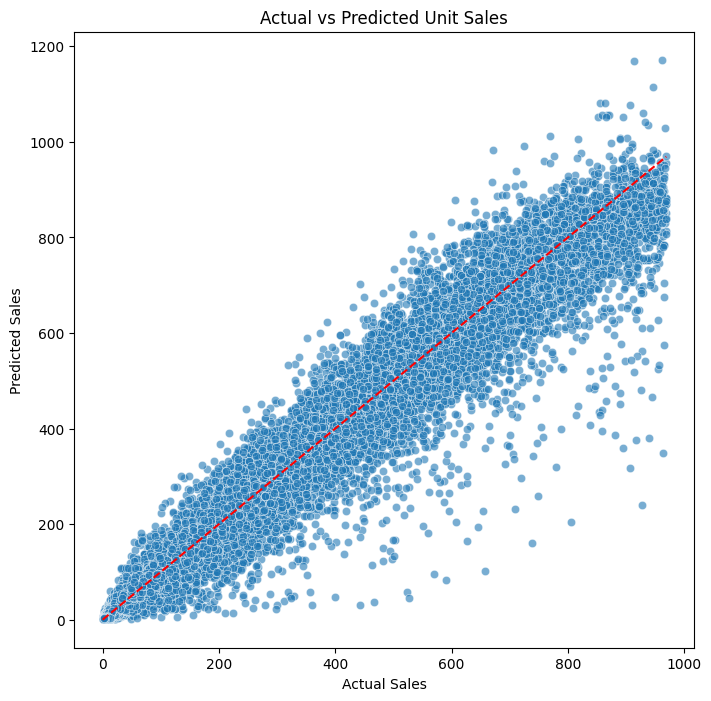

In [103]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x='Actual', y='Predicted', data=comparison_df_unit_sales, alpha=0.6)
plt.plot([0, comparison_df_unit_sales['Actual'].max()], [0, comparison_df_unit_sales['Actual'].max()], '--', color='red')
plt.title("Actual vs Predicted Unit Sales")
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.show()

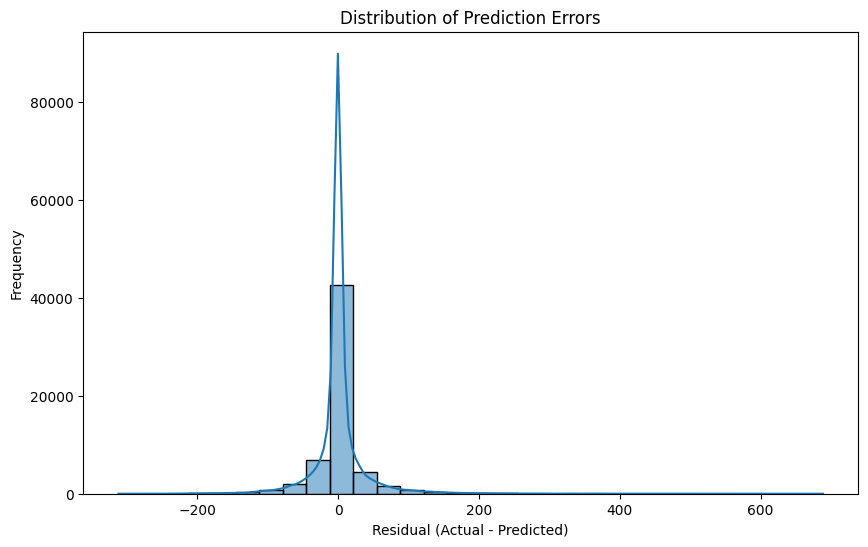

In [104]:
plt.figure(figsize=(10, 6))
sns.histplot(comparison_df_unit_sales['Residual'], kde=True, bins=30)
plt.title("Distribution of Prediction Errors")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()

In [105]:
# Create comparison dataframe
comparison_df_transactions = pd.DataFrame({
    'Actual': valid['transactions'],
    'Predicted': y_pred_transactions
})

# Add residuals (errors)
comparison_df_transactions['Residual'] = comparison_df_transactions['Actual'] - comparison_df_transactions['Predicted']

# Add percentage error
comparison_df_transactions['Pct_Error'] = (comparison_df_transactions['Residual'] / comparison_df_transactions['Actual']) * 100

print(comparison_df_transactions.sample(20))

           Actual      Predicted     Residual  Pct_Error
1566353    7476.0    8826.535244 -1350.535244 -18.064944
1308403  236340.0  242780.473292 -6440.473292  -2.725088
535545     8418.0    5164.224359  3253.775641  38.652597
148215     6916.0    6100.323785   815.676215  11.794046
1822151   52428.0   51546.629230   881.370770   1.681107
402709    35526.0   31958.017280  3567.982720  10.043300
1565738    9352.0    9415.361517   -63.361517  -0.677518
148362    40975.0   37286.292976  3688.707024   9.002336
1307673   14464.0   16192.799671 -1728.799671 -11.952431
1178257    8460.0    6554.563750  1905.436250  22.522887
149527     1320.0    1973.457142  -653.457142 -49.504329
275354    40200.0   38434.128355  1765.871645   4.392716
1436413    4380.0    5060.014513  -680.014513 -15.525446
18478      1506.0     991.883787   514.116213  34.137863
1952221   22372.0   21409.403579   962.596421   4.302684
1437324   33792.0   26641.242470  7150.757530  21.161096
403881     8000.0    3989.75394

In [106]:
joblib.dump(model_sales, 'lightgbm_sales_model_2.11.pkl')
joblib.dump(model_transactions, 'lightgbm_transactions_model_2.11.pkl')
print("Model saved")

Model saved


In [107]:
data.head()

,date,store_nbr,family,unit_sales,onpromotion,city,state,store_type,perishable,transactions,...,sales_roll_mean_14,sales_roll_mean_28,trans_lag_1,trans_lag_7,trans_lag_14,trans_roll_mean_7,trans_roll_mean_14,mean_transactions_family,mean_transactions_store,mean_transactions_store_family
1716381,2013-02-06,1,0,1.0,0,18,12,3,0,1853.0,...,3.142857,2.714286,6856.0,3885.0,1786.0,4270.571429,3828.500000,8357.451252,47138.102711,4386.810663
1458126,2013-02-07,1,0,1.0,0,18,12,3,0,1727.0,...,3.142857,2.678571,1853.0,1084.0,4167.0,3980.285714,3833.285714,8357.451252,47138.102711,4386.810663
425588,2013-02-08,1,0,2.0,0,18,12,3,0,3756.0,...,2.857143,2.607143,1727.0,3476.0,1521.0,4072.142857,3659.000000,8357.451252,47138.102711,4386.810663
1070834,2013-02-09,1,0,4.0,0,18,12,3,0,4416.0,...,2.785714,2.571429,3756.0,3544.0,1770.0,4112.142857,3818.642857,8357.451252,47138.102711,4386.810663
1716600,2013-02-10,1,0,1.0,0,18,12,3,0,374.0,...,3.000000,2.535714,4416.0,5631.0,1762.0,4236.714286,4007.642857,8357.451252,47138.102711,4386.810663


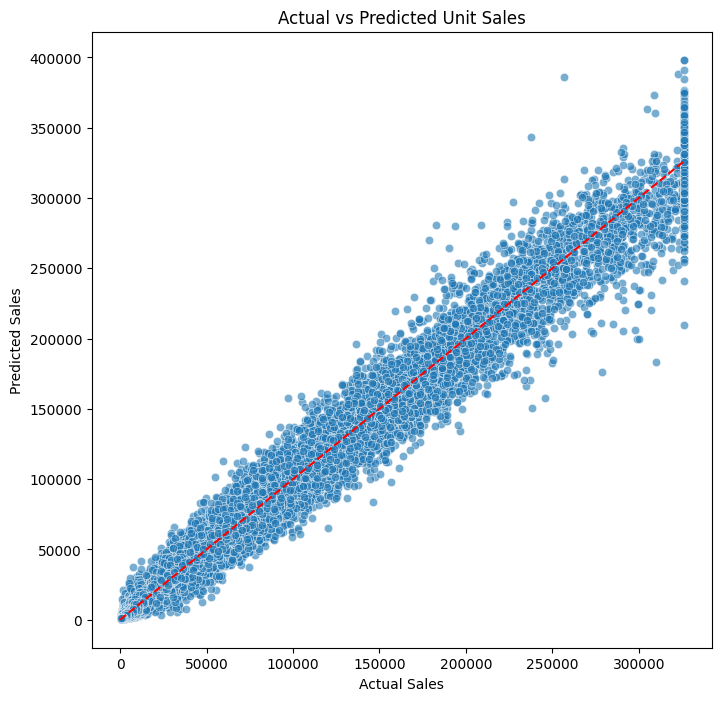

In [108]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x='Actual', y='Predicted', data=comparison_df_transactions, alpha=0.6)
plt.plot([0, comparison_df_transactions['Actual'].max()], [0, comparison_df_transactions['Actual'].max()], '--', color='red')
plt.title("Actual vs Predicted Unit Sales")
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.show()

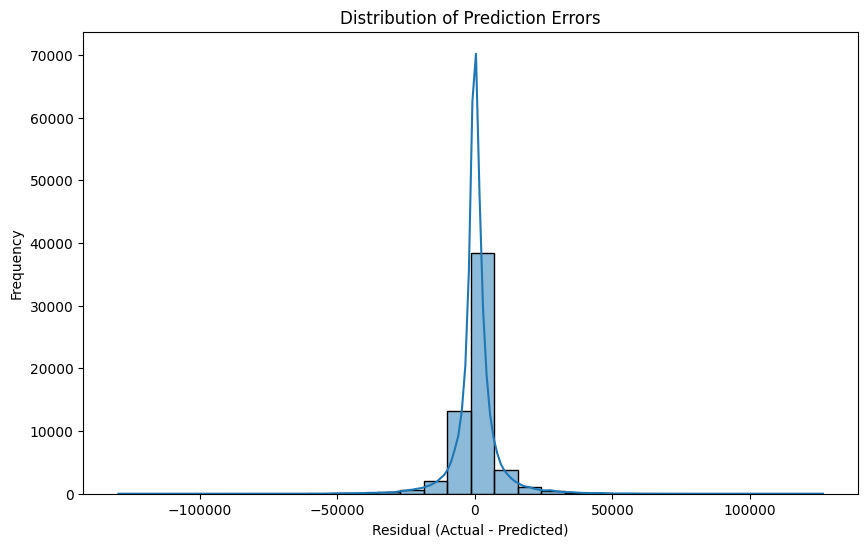

In [109]:
plt.figure(figsize=(10, 6))
sns.histplot(comparison_df_transactions['Residual'], kde=True, bins=30)
plt.title("Distribution of Prediction Errors")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()

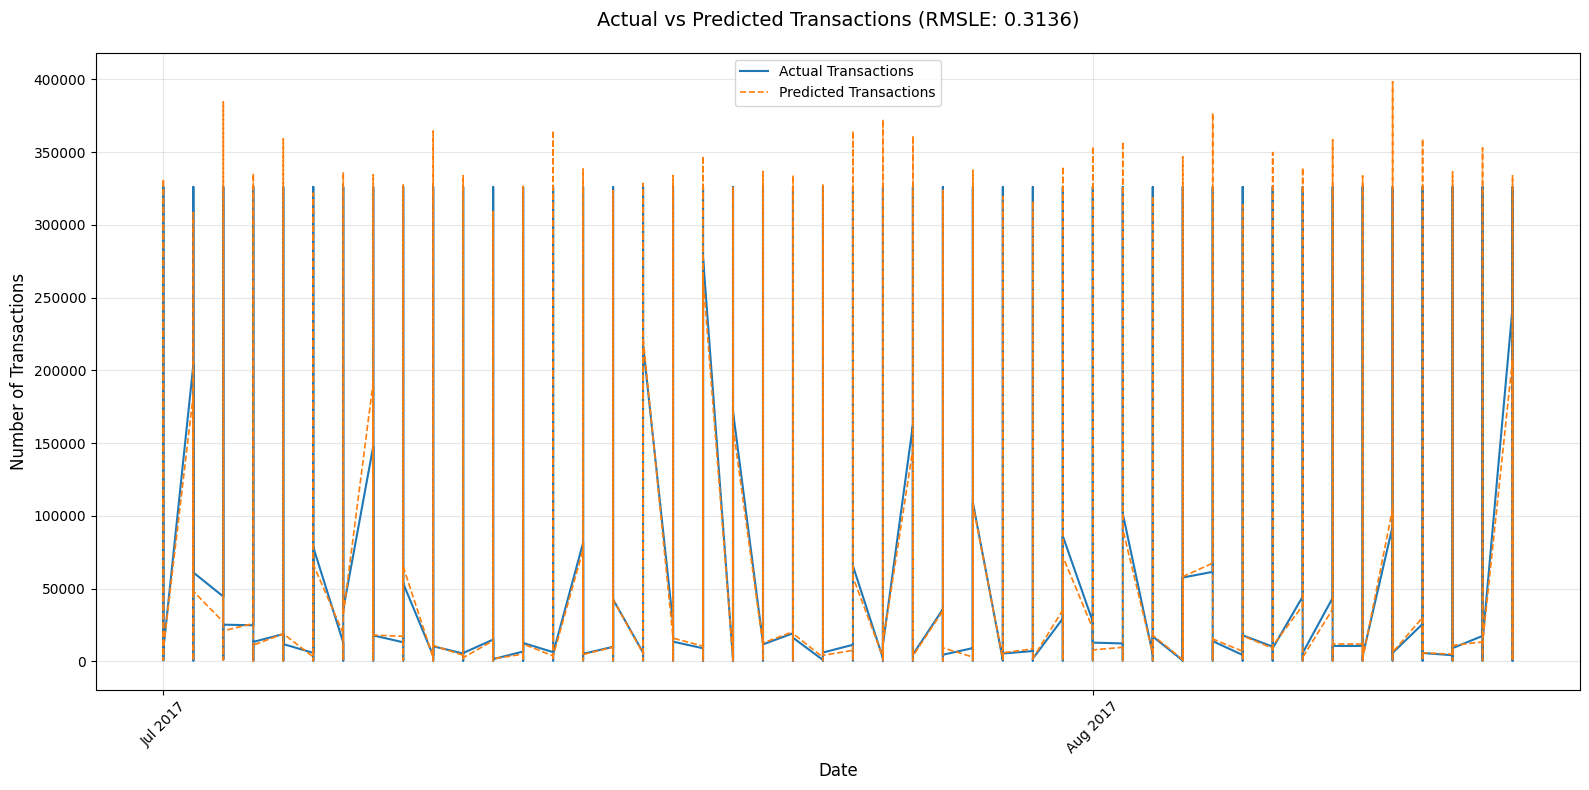

In [110]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create DataFrame with actual and predicted values
results = valid[['date', 'transactions']].copy()
results['predicted'] = np.maximum(0, y_pred_transactions)
results = results.sort_values('date').reset_index(drop=True)

# Create plot
plt.figure(figsize=(16, 8))
plt.plot(results['date'], results['transactions'], label='Actual Transactions', color='#1f77b4', linewidth=1.5)
plt.plot(results['date'], results['predicted'], label='Predicted Transactions', color='#ff7f0e', linestyle='--', linewidth=1.2)

# Formatting
plt.title(f'Actual vs Predicted Transactions (RMSLE: {rmsle_transactions:.4f})', fontsize=14, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

# Date formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)
plt.tight_layout()
# Highlight important periods

plt.show()

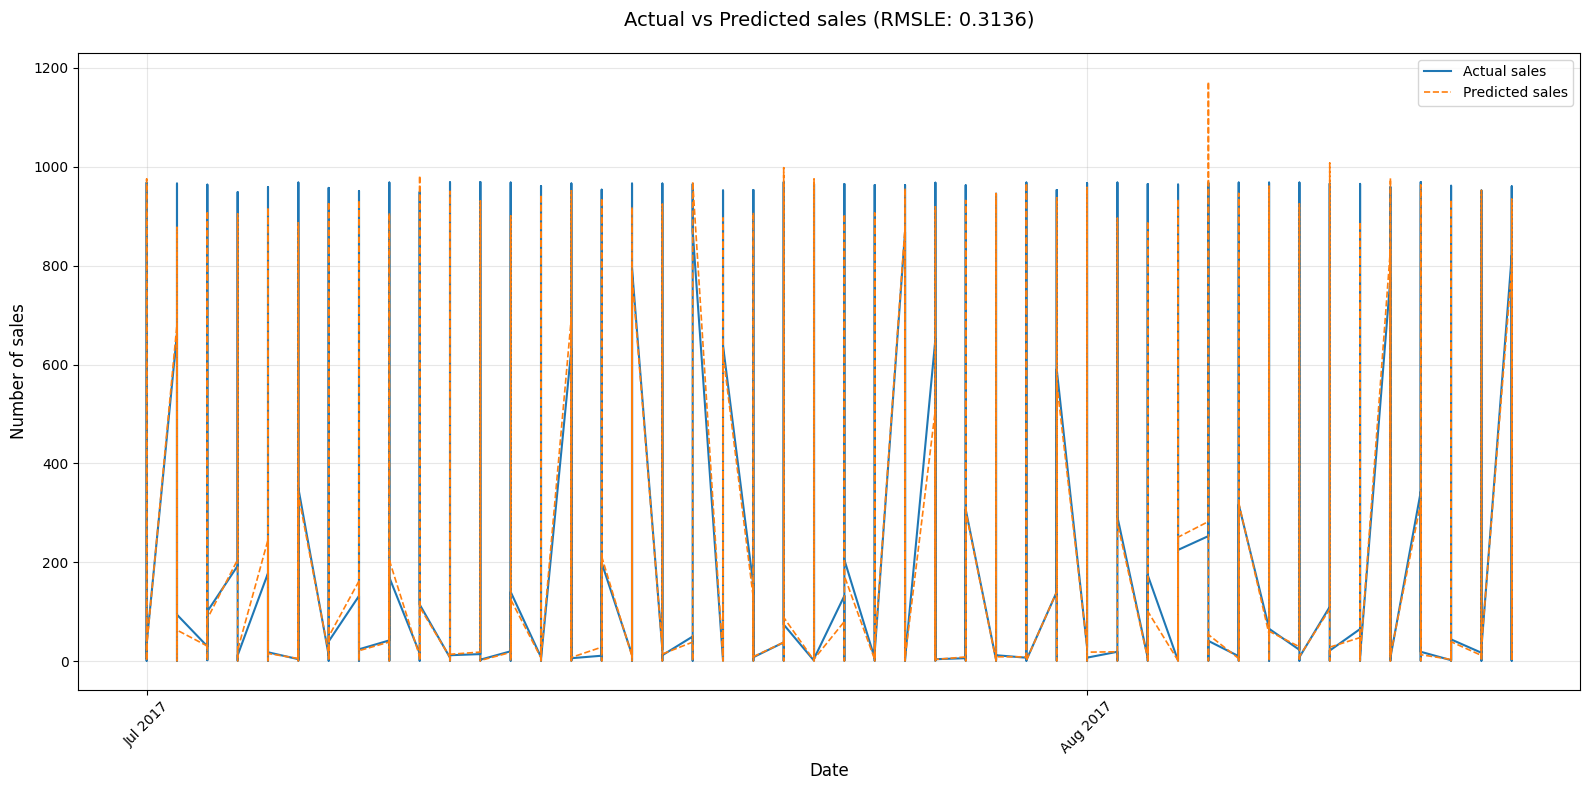

In [111]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create DataFrame with actual and predicted values
results = valid[['date', 'unit_sales']].copy()
results['predicted'] = np.maximum(0, y_pred_sales)
results = results.sort_values('date').reset_index(drop=True)

# Create plot
plt.figure(figsize=(16, 8))
plt.plot(results['date'], results['unit_sales'], label='Actual sales', color='#1f77b4', linewidth=1.5)
plt.plot(results['date'], results['predicted'], label='Predicted sales', color='#ff7f0e', linestyle='--', linewidth=1.2)

# Formatting
plt.title(f'Actual vs Predicted sales (RMSLE: {rmsle_transactions:.4f})', fontsize=14, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of sales', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

# Date formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)
plt.tight_layout()
# Highlight important periods

plt.show()